In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
train_id = pd.read_csv('creditcard_dataset2.csv/train_identity.csv')
train_trans = pd.read_csv('creditcard_dataset2.csv/train_transaction.csv')

In [2]:
print(train_id.shape)
print(train_trans.shape)

(144233, 41)
(590540, 394)


In [3]:
#Merge Transaction and Identity table
train = train_trans.merge(train_id, how='left', on='TransactionID') 
#Check for missing values
train.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
id_36             449555
id_37             449555
id_38             449555
DeviceType        449730
DeviceInfo        471874
Length: 434, dtype: int64

In [4]:
del train_id
del train_trans

In [5]:
#Remove high missing value columns
columnsToDelete = []
for col in train.columns:
    if(train[col].isnull().sum()/len(train[col]) >= 0.8):
        print(col, "% NaN:", train[col].isnull().sum()/len(train[col]))
        columnsToDelete.append(col)

dist2 % NaN: 0.9362837403054831
D6 % NaN: 0.8760676668811597
D7 % NaN: 0.9340992989467267
D8 % NaN: 0.8731229044603245
D9 % NaN: 0.8731229044603245
D12 % NaN: 0.8904104717715988
D13 % NaN: 0.8950926270870728
D14 % NaN: 0.8946946862193924
V138 % NaN: 0.8612371727571375
V139 % NaN: 0.8612371727571375
V140 % NaN: 0.8612371727571375
V141 % NaN: 0.8612371727571375
V142 % NaN: 0.8612371727571375
V143 % NaN: 0.8612270125647712
V144 % NaN: 0.8612270125647712
V145 % NaN: 0.8612270125647712
V146 % NaN: 0.8612371727571375
V147 % NaN: 0.8612371727571375
V148 % NaN: 0.8612371727571375
V149 % NaN: 0.8612371727571375
V150 % NaN: 0.8612270125647712
V151 % NaN: 0.8612270125647712
V152 % NaN: 0.8612270125647712
V153 % NaN: 0.8612371727571375
V154 % NaN: 0.8612371727571375
V155 % NaN: 0.8612371727571375
V156 % NaN: 0.8612371727571375
V157 % NaN: 0.8612371727571375
V158 % NaN: 0.8612371727571375
V159 % NaN: 0.8612270125647712
V160 % NaN: 0.8612270125647712
V161 % NaN: 0.8612371727571375
V162 % NaN: 0.8612

In [6]:
train = train.drop(columns=columnsToDelete)

In [7]:
v_columns = []
for col in ['V'+str(x) for x in range(1,340)]:
    if col in train.columns:
        v_columns.append(col)

In [8]:
cat_label_features = ["card1","card2","card3","card5", "addr1", "addr2", "id_13","id_17","id_19","id_20","id_31","DeviceInfo"]
num_features = []
cat_onehot_features = ["ProductCD","card4","card6", "M1","M2","M3","M4","M5","M6","M7","M8","M9","id_12","id_15",
                      "id_16","id_28","id_29","id_35","id_36","id_37","id_38","DeviceType","P_emaildomain",
                       "R_emaildomain"]
for col in train.columns:
    if col not in cat_label_features and col not in v_columns and col not in cat_onehot_features:
        num_features.append(col)
num_features.remove('isFraud')
num_features.remove('TransactionID')

print(len(cat_onehot_features))
print(len(cat_label_features))
print(len(num_features))

24
12
30


In [9]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other',
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft',
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo',
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other',
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple',
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other',
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    train[c] = train[c].map(emails)

In [10]:
train["new_browser"] = np.zeros(train.shape[0])

def setBinaryBrowser(df):
    df.loc[df["id_31"]=="samsung browser 7.0",'new_browser']=1
    df.loc[df["id_31"]=="opera 53.0",'new_browser']=1
    df.loc[df["id_31"]=="mobile safari 10.0",'new_browser']=1
    df.loc[df["id_31"]=="google search application 49.0",'new_browser']=1
    df.loc[df["id_31"]=="firefox 60.0",'new_browser']=1
    df.loc[df["id_31"]=="edge 17.0",'new_browser']=1
    df.loc[df["id_31"]=="chrome 69.0",'new_browser']=1
    df.loc[df["id_31"]=="chrome 67.0 for android",'new_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for android",'new_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for ios",'new_browser']=1
    df.loc[df["id_31"]=="chrome 64.0",'new_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for android",'new_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for ios",'new_browser']=1
    df.loc[df["id_31"]=="chrome 65.0",'new_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for android",'new_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for ios",'new_browser']=1
    df.loc[df["id_31"]=="chrome 66.0",'new_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for android",'new_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for ios",'new_browser']=1
    return df

train = setBinaryBrowser(train)
cat_label_features.remove('id_31')
cat_onehot_features.append('new_browser')
train = train.drop(columns='id_31')

In [11]:
def transform_hour(df, col='TransactionDT'):
    hours = df[col] / (3600)        
    hours = np.floor(hours) % 24
    return hours

train['hours'] = transform_hour(train)
num_features.remove('TransactionDT')
cat_onehot_features.append('hours')

In [12]:
num_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())  
    ]
)

v_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

cat_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder())
    ]
)

preprocessor_c = ColumnTransformer(
    transformers = [
        ('cat', cat_transformer, cat_onehot_features)
    ]
)

preprocessor_v = ColumnTransformer(
    transformers = [
        ('v', v_transformer, v_columns)
    ]
)

preprocessor_num = ColumnTransformer(
    transformers = [
        ('num', num_transformer, num_features)
    ]
)

In [13]:
for col in cat_label_features:
    train[col] = train[col].fillna(train[col].mode()[0])

le = LabelEncoder()
train[cat_label_features] = train[["card1","card2","card3","card5", "addr1", "addr2", "id_13","id_17",
                                   "id_19","id_20","DeviceInfo"]].apply(le.fit_transform)

In [14]:
from sklearn.model_selection import train_test_split
y = train.isFraud.values
x_train, x_test, y_train, y_test = train_test_split(train, y, stratify = y, test_size = 0.25, random_state = 5)

In [15]:
x_train_cat_label = x_train[cat_label_features]
x_test_cat_label = x_test[cat_label_features]
mms = MinMaxScaler()
x_train_cat_label = mms.fit_transform(x_train_cat_label)
x_test_cat_label = mms.transform(x_test_cat_label)
print(x_train_cat_label.shape)

(442905, 11)


In [16]:
preprocessor_c.fit(x_train[cat_onehot_features])
x_train_cat_onehot = preprocessor_c.transform(x_train[cat_onehot_features])
x_test_cat_onehot = preprocessor_c.transform(x_test[cat_onehot_features])

In [17]:
x_train_cat_onehot = x_train_cat_onehot.toarray()
x_test_cat_onehot = x_test_cat_onehot.toarray()
print(x_train_cat_onehot.shape)

(442905, 97)


In [18]:
preprocessor_v.fit(x_train[v_columns])
x_train_v = preprocessor_v.transform(x_train[v_columns])
x_test_v = preprocessor_v.transform(x_test[v_columns])
print(x_train_v.shape)

(442905, 292)


In [19]:
#Dimension reduction
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
x_train_v = pca.fit_transform(x_train_v)
x_test_v = pca.transform(x_test_v)
var_explained = pca.explained_variance_ratio_.sum()
print(x_train_v.shape)

(442905, 85)


In [20]:
preprocessor_num.fit(x_train[num_features])
x_train_num = preprocessor_num.transform(x_train[num_features])
x_test_num = preprocessor_num.transform(x_test[num_features])
print(x_train_num.shape)
print(x_test_num.shape)

(442905, 29)
(147635, 29)


In [21]:
x_train_num = x_train_num.astype('float32')
x_test_num = x_test_num.astype('float32')
x_train = np.concatenate((x_train_num, x_train_cat_label, x_train_v, x_train_cat_onehot), axis = 1)
x_test = np.concatenate((x_test_num, x_test_cat_label, x_test_v, x_test_cat_onehot), axis = 1)
print(x_train.shape)
print(x_test.shape)

(442905, 222)
(147635, 222)


In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, precision_score, matthews_corrcoef


def print_classification_result(true, predict):
    print(f"Accuracy Score: {accuracy_score(true, predict) * 100:.2f}%")
    print(f"Confusion Matrix: \n {confusion_matrix(true, predict)}\n")
    print(f"MCC_Score:{matthews_corrcoef(true, predict)}\n")
    print(f"f1_score: \n {f1_score(true, predict)}\n")
    print(f"recall_score: \n {recall_score(true, predict)}\n")
    print(f"Precision_Score:{precision_score(true, predict)}")

## Convolution Neural Network

In [23]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)

In [33]:
cnn = tf.keras.models.Sequential()

In [34]:
cnn.add(tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, activation = 'relu', input_shape = [x_train.shape[1], 1]))
cnn.add(tf.keras.layers.MaxPool1D(pool_size = 2, strides = 1))

In [35]:
cnn.add(tf.keras.layers.Conv1D(filters = 64, kernel_size = 2, activation = 'relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size = 2, strides = 1))

In [36]:
cnn.add(tf.keras.layers.Flatten())

In [37]:
cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))

In [38]:
cnn.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

In [39]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [40]:
loss = cnn.fit(x_train, y_train, batch_size = 32, epochs = 8, verbose = 1, validation_split = 0.3)

Epoch 1/8
9689/9689 [==============================] - 221s 23ms/step - loss: 0.1087 - accuracy: 0.9716 - val_loss: 0.1015 - val_accuracy: 0.9727
Epoch 2/8
9689/9689 [==============================] - 229s 24ms/step - loss: 0.0986 - accuracy: 0.9734 - val_loss: 0.0959 - val_accuracy: 0.9738
Epoch 3/8
9689/9689 [==============================] - 228s 24ms/step - loss: 0.0925 - accuracy: 0.9748 - val_loss: 0.0908 - val_accuracy: 0.9749
Epoch 4/8
9689/9689 [==============================] - 242s 25ms/step - loss: 0.0881 - accuracy: 0.9759 - val_loss: 0.0887 - val_accuracy: 0.9756
Epoch 5/8
9689/9689 [==============================] - 235s 24ms/step - loss: 0.0842 - accuracy: 0.9768 - val_loss: 0.0868 - val_accuracy: 0.9761
Epoch 6/8
9689/9689 [==============================] - 232s 24ms/step - loss: 0.0803 - accuracy: 0.9777 - val_loss: 0.0864 - val_accuracy: 0.9764
Epoch 7/8
9689/9689 [==============================] - 237s 24ms/step - loss: 0.0766 - accuracy: 0.9785 - val_loss: 0.0903 -

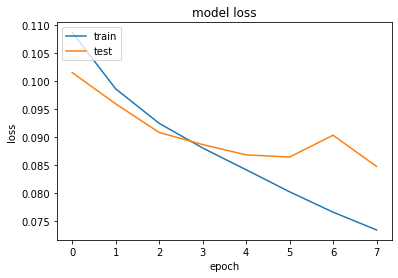

In [41]:
plt.plot(loss.history['loss'])
plt.plot(loss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
y_pred = cnn.predict(x_test)
y_pred = np.round(y_pred)
print_classification_result(y_test, y_pred)

Accuracy Score: 97.67%
Confusion Matrix: 
 [[142043    426]
 [  3010   2156]]

MCC_Score:0.5808546890232605

f1_score: 
 0.5565307176045431

recall_score: 
 0.4173441734417344

Precision_Score:0.8350116189000775


## Parameter testing

In [28]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv1D(filters = 64, kernel_size = 4, activation = 'relu', input_shape = [x_train.shape[1], 1]))
cnn.add(tf.keras.layers.MaxPool1D(pool_size = 2, strides = 1))
cnn.add(tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, activation = 'relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size = 2, strides = 1))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
cnn.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [29]:
loss = cnn.fit(x_train, y_train, batch_size = 32, epochs = 8, verbose = 1, validation_split = 0.3)

Epoch 1/8
9689/9689 [==============================] - 246s 25ms/step - loss: 0.1092 - accuracy: 0.9714 - val_loss: 0.0991 - val_accuracy: 0.9728
Epoch 2/8
9689/9689 [==============================] - 235s 24ms/step - loss: 0.0988 - accuracy: 0.9734 - val_loss: 0.0941 - val_accuracy: 0.9738
Epoch 3/8
9689/9689 [==============================] - 235s 24ms/step - loss: 0.0930 - accuracy: 0.9747 - val_loss: 0.0927 - val_accuracy: 0.9745
Epoch 4/8
9689/9689 [==============================] - 279s 29ms/step - loss: 0.0877 - accuracy: 0.9758 - val_loss: 0.0878 - val_accuracy: 0.9756
Epoch 5/8
9689/9689 [==============================] - 426s 44ms/step - loss: 0.0834 - accuracy: 0.9768 - val_loss: 0.0867 - val_accuracy: 0.9760
Epoch 6/8
9689/9689 [==============================] - 443s 46ms/step - loss: 0.0796 - accuracy: 0.9777 - val_loss: 0.0868 - val_accuracy: 0.9765
Epoch 7/8
9689/9689 [==============================] - 259s 27ms/step - loss: 0.0758 - accuracy: 0.9787 - val_loss: 0.0867 -

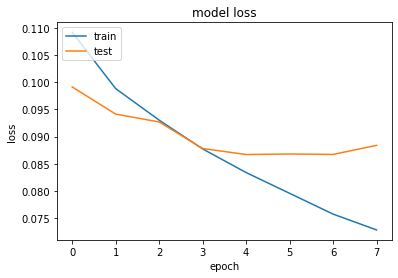

In [30]:
plt.plot(loss.history['loss'])
plt.plot(loss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
y_pred = cnn.predict(x_test)
y_pred = np.round(y_pred)
print_classification_result(y_test, y_pred)

Accuracy Score: 97.67%
Confusion Matrix: 
 [[142166    303]
 [  3136   2030]]

MCC_Score:0.5758759614241648

f1_score: 
 0.5414055207360982

recall_score: 
 0.39295392953929537

Precision_Score:0.8701243034719246


In [25]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = 'relu', input_shape = [x_train.shape[1], 1]))
cnn.add(tf.keras.layers.MaxPool1D(pool_size = 2, strides = 1))
cnn.add(tf.keras.layers.Conv1D(filters = 128, kernel_size = 2, activation = 'relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size = 2, strides = 1))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
cnn.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [26]:
loss = cnn.fit(x_train, y_train, batch_size = 32, epochs = 8, verbose = 1, validation_split = 0.3)

Epoch 1/8
9689/9689 [==============================] - 495s 51ms/step - loss: 0.1113 - accuracy: 0.9704 - val_loss: 0.1012 - val_accuracy: 0.9727
Epoch 2/8
9689/9689 [==============================] - 554s 57ms/step - loss: 0.0995 - accuracy: 0.9733 - val_loss: 0.0949 - val_accuracy: 0.9742
Epoch 3/8
9689/9689 [==============================] - 608s 63ms/step - loss: 0.0931 - accuracy: 0.9748 - val_loss: 0.0911 - val_accuracy: 0.9750
Epoch 4/8
9689/9689 [==============================] - 524s 54ms/step - loss: 0.0882 - accuracy: 0.9760 - val_loss: 0.0878 - val_accuracy: 0.9757
Epoch 5/8
9689/9689 [==============================] - 514s 53ms/step - loss: 0.0840 - accuracy: 0.9768 - val_loss: 0.0900 - val_accuracy: 0.9756
Epoch 6/8
9689/9689 [==============================] - 542s 56ms/step - loss: 0.0805 - accuracy: 0.9778 - val_loss: 0.0998 - val_accuracy: 0.9732
Epoch 7/8
9689/9689 [==============================] - 506s 52ms/step - loss: 0.0775 - accuracy: 0.9783 - val_loss: 0.0852 -

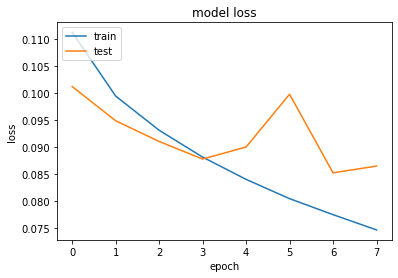

In [27]:
plt.plot(loss.history['loss'])
plt.plot(loss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
y_pred = cnn.predict(x_test)
y_pred = np.round(y_pred)
print_classification_result(y_test, y_pred)

Accuracy Score: 97.58%
Confusion Matrix: 
 [[141921    548]
 [  3025   2141]]

MCC_Score:0.5642240556573745

f1_score: 
 0.5451304901336729

recall_score: 
 0.41444057297715836

Precision_Score:0.7962067683153589


In [24]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv1D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = [x_train.shape[1], 1]))
cnn.add(tf.keras.layers.MaxPool1D(pool_size = 2, strides = 1))
cnn.add(tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, activation = 'relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size = 2, strides = 1))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
cnn.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [25]:
loss = cnn.fit(x_train, y_train, batch_size = 32, epochs = 8, verbose = 1, validation_split = 0.3)

Epoch 1/8
9689/9689 [==============================] - 142s 15ms/step - loss: 0.1081 - accuracy: 0.9716 - val_loss: 0.0991 - val_accuracy: 0.9731
Epoch 2/8
9689/9689 [==============================] - 126s 13ms/step - loss: 0.0988 - accuracy: 0.9736 - val_loss: 0.0961 - val_accuracy: 0.9735
Epoch 3/8
9689/9689 [==============================] - 136s 14ms/step - loss: 0.0931 - accuracy: 0.9747 - val_loss: 0.0934 - val_accuracy: 0.9752
Epoch 4/8
9689/9689 [==============================] - 132s 14ms/step - loss: 0.0877 - accuracy: 0.9761 - val_loss: 0.0917 - val_accuracy: 0.9753
Epoch 5/8
9689/9689 [==============================] - 116s 12ms/step - loss: 0.0830 - accuracy: 0.9772 - val_loss: 0.0875 - val_accuracy: 0.9764
Epoch 6/8
9689/9689 [==============================] - 115s 12ms/step - loss: 0.0785 - accuracy: 0.9784 - val_loss: 0.0858 - val_accuracy: 0.9768
Epoch 7/8
9689/9689 [==============================] - 114s 12ms/step - loss: 0.0751 - accuracy: 0.9792 - val_loss: 0.0898 -

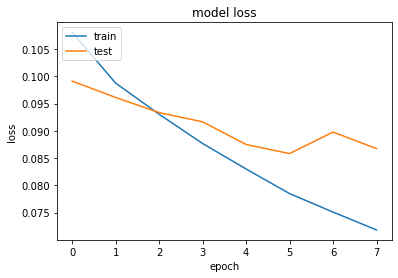

In [26]:
plt.plot(loss.history['loss'])
plt.plot(loss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
y_pred = cnn.predict(x_test)
y_pred = np.round(y_pred)
print_classification_result(y_test, y_pred)

Accuracy Score: 97.68%
Confusion Matrix: 
 [[142114    355]
 [  3076   2090]]

MCC_Score:0.5789464050415332

f1_score: 
 0.5492050978846407

recall_score: 
 0.4045683313975997

Precision_Score:0.8548057259713702
